# Install prophet

In [1]:
!pip install -U prophet -q

In [2]:
from prophet import Prophet
import pandas as pd
from pathlib import Path

In [11]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 5]

In [3]:
milk_file = Path('/content/milk_production.csv')
milk = pd.read_csv(milk_file,
                   header=0,
                   parse_dates=['ds'],
                   names=['ds', 'y'])
milk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      168 non-null    datetime64[ns]
 1   y       168 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


In [5]:
milk.head()

,ds,y
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727


## Split the Dataset into Train and Test
Notice we are preserving temporal order

In [7]:
def split_data(data, test_split):
    """Split time series data into training and test sets.

    Args:
        data (pd.Series or pd.DataFrame): Time series data to split
        test_split (int): Number of periods to use for testing

    Returns:
        tuple: (train_data, test_data)
    """
    t_idx = test_split
    train, test = data[ : -t_idx], data[-t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [8]:
test_split = 12
train, test = split_data(milk, test_split)

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

train: 156 , test: 12
Train: (156, 2)
Test: (12, 2)


<Axes: title={'center': 'Monthly Milk Production'}, xlabel='ds'>

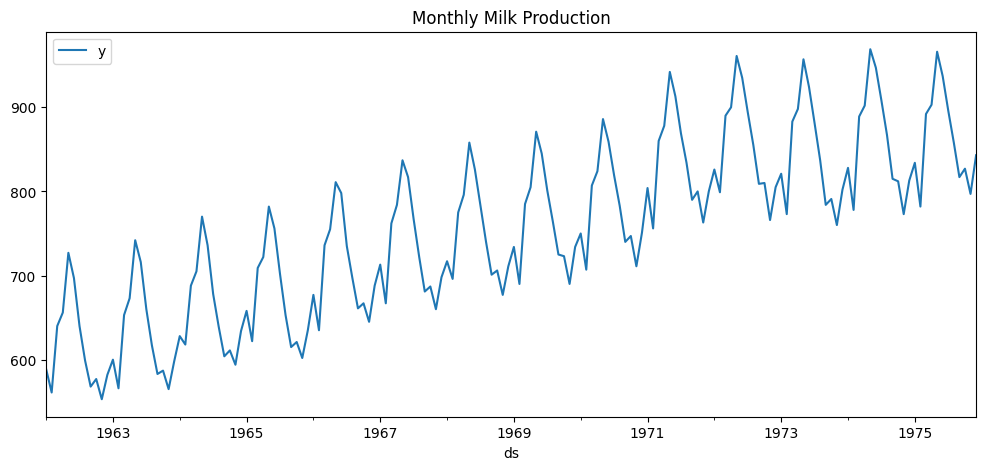

In [12]:
milk.set_index('ds').plot(title='Monthly Milk Production')

## Create and train the model

In [14]:
model = Prophet(seasonality_mode='additive',
                interval_width=0.80)

model.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3rb7k9g1/mir41vj5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3rb7k9g1/wlb3dymt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25805', 'data', 'file=/tmp/tmp3rb7k9g1/mir41vj5.json', 'init=/tmp/tmp3rb7k9g1/wlb3dymt.json', 'output', 'file=/tmp/tmp3rb7k9g1/prophet_modell39azm90/prophet_model-20250915082644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:26:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:26:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [15]:
model.seasonalities


OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

In [16]:
future = model.make_future_dataframe(len(test), freq='MS')


In [17]:
future

,ds
0,1962-01-01
1,1962-02-01
2,1962-03-01
3,1962-04-01
4,1962-05-01
...,...
163,1975-08-01
164,1975-09-01
165,1975-10-01
166,1975-11-01


## Forecast ahead

In [18]:
forecast = model.predict(future)

In [19]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1962-01-01,607.805250,576.973528,596.831291,607.805250,607.805250,-20.997881,-20.997881,-20.997881,-20.997881,-20.997881,-20.997881,0.0,0.0,0.0,586.807369
1,1962-02-01,609.502304,536.898918,556.745900,609.502304,609.502304,-62.156969,-62.156969,-62.156969,-62.156969,-62.156969,-62.156969,0.0,0.0,0.0,547.345335
2,1962-03-01,611.035127,631.974865,650.194454,611.035127,611.035127,30.312090,30.312090,30.312090,30.312090,30.312090,30.312090,0.0,0.0,0.0,641.347216
3,1962-04-01,612.732181,649.449212,668.887144,612.732181,612.732181,46.255284,46.255284,46.255284,46.255284,46.255284,46.255284,0.0,0.0,0.0,658.987464
4,1962-05-01,614.374491,711.594744,731.194057,614.374491,614.374491,107.488346,107.488346,107.488346,107.488346,107.488346,107.488346,0.0,0.0,0.0,721.862837


## plotting with prophet

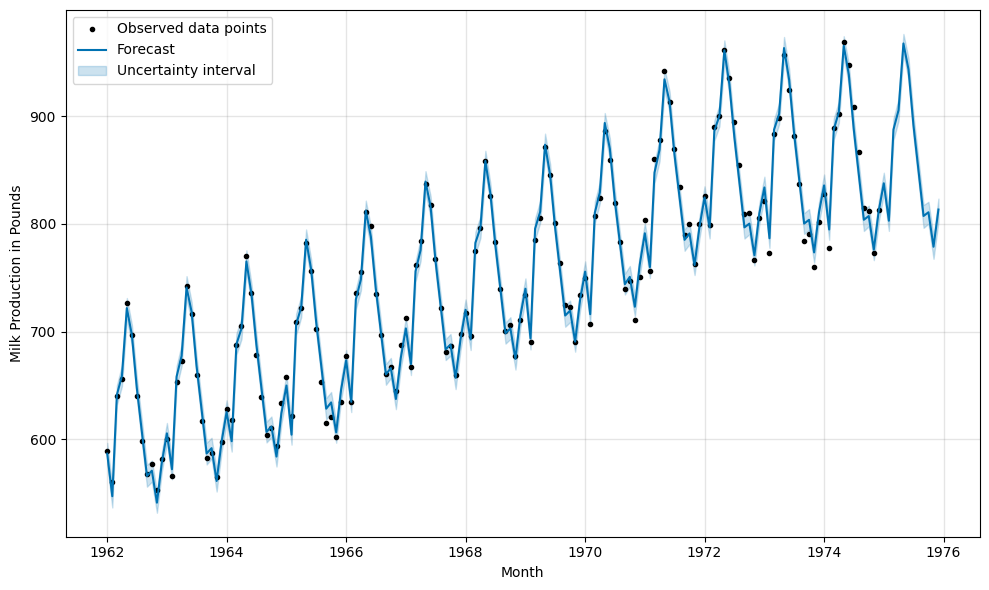

In [20]:
model.plot(forecast,
           ylabel='Milk Production in Pounds',
           xlabel='Month',
           include_legend=True);

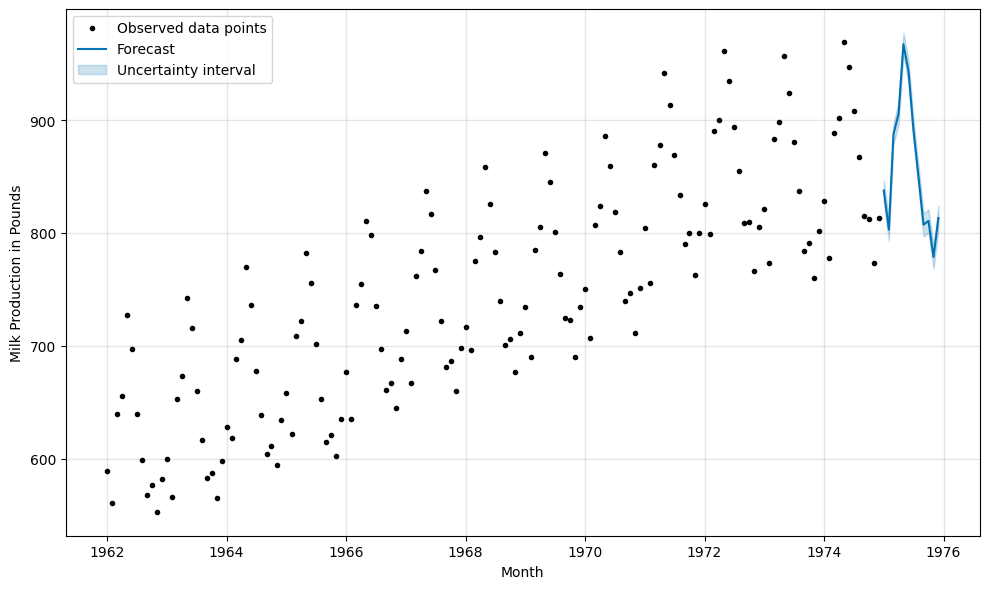

In [21]:
model.plot(model.predict(test),
           ylabel='Milk Production in Pounds',
           xlabel='Month',
          include_legend=True);


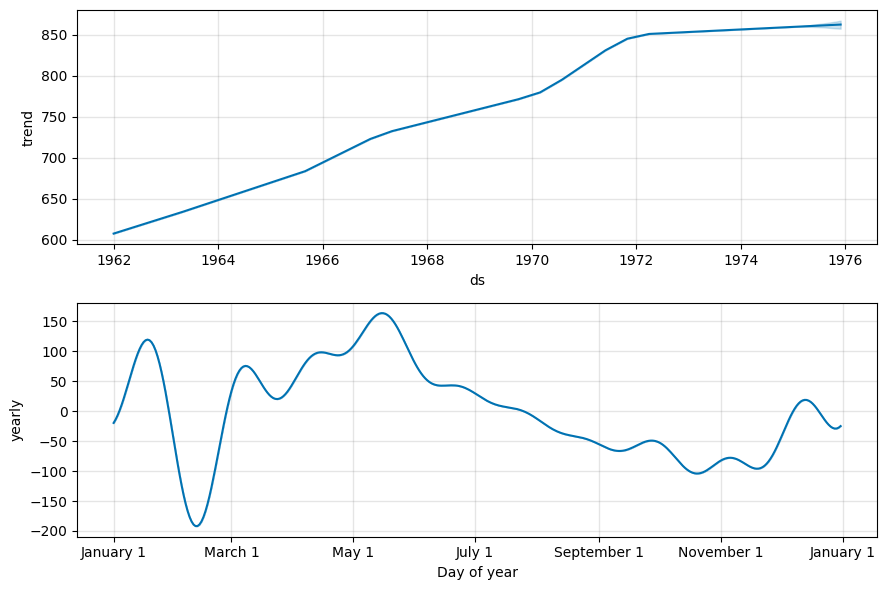

In [22]:
model.plot_components(forecast);


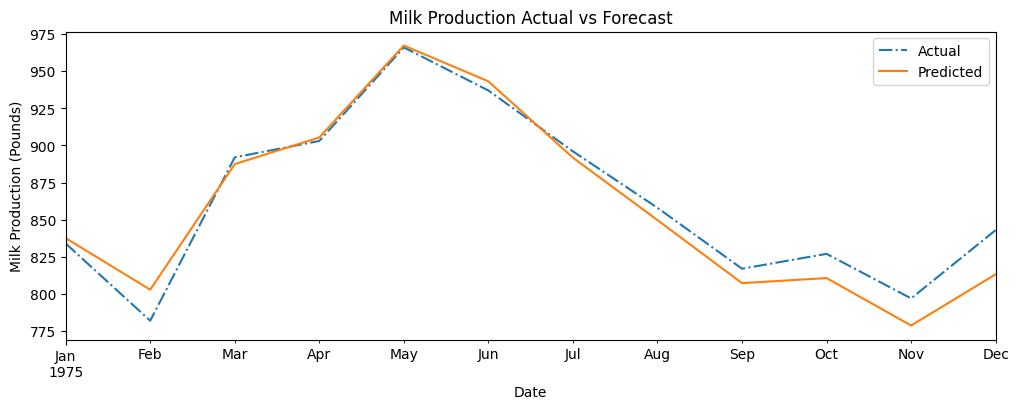

In [23]:
n = len(test)
ax = test.plot(x='ds', y='y',
               label='Actual',
               style='-.',
               figsize=(12,4), xlabel='Date')

forecast.tail(n).plot(x='ds', y='yhat',
              label='Predicted',
              ax=ax,
              title='Milk Production Actual vs Forecast',
              xlabel='Date',
              ylabel='Milk Production (Pounds)');

# Changepoint Detection

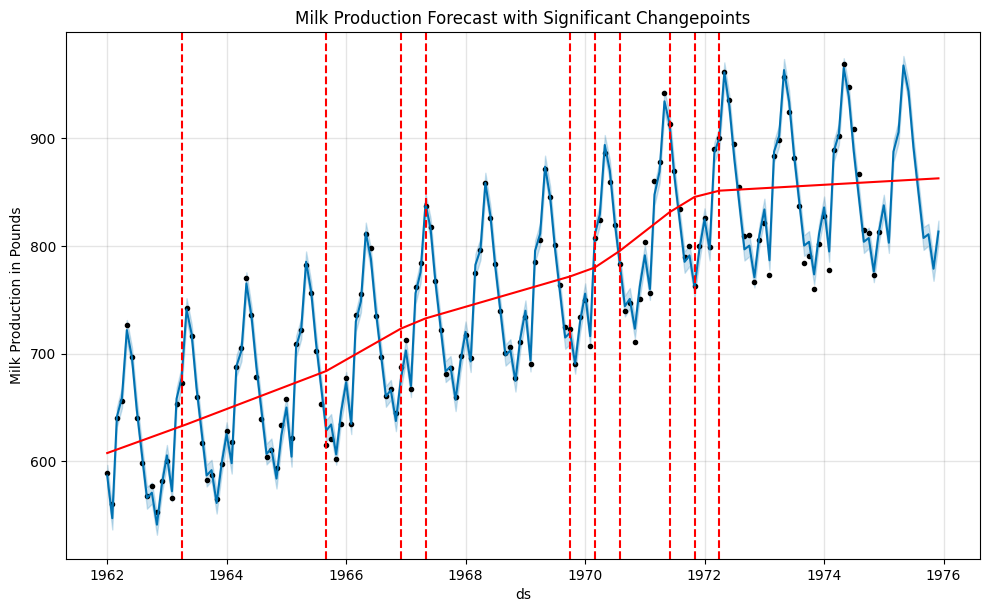

In [24]:
from prophet.plot import add_changepoints_to_plot

# Create base plot with forecast
fig = model.plot(forecast, ylabel='Milk Production in Pounds')
# Add changepoint visualization
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.title('Milk Production Forecast with Significant Changepoints');

## Adding Holidays and Regressors

In [25]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

In [26]:
retail = Path('/content/weekly_sales.csv')
retail_df = pd.read_csv(retail, parse_dates=['Date'])
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          143 non-null    datetime64[ns]
 1   Weekly_Sales  143 non-null    float64       
 2   Holiday_Flag  143 non-null    float64       
 3   Temperature   143 non-null    float64       
 4   Fuel_Price    143 non-null    float64       
 5   CPI           143 non-null    float64       
 6   Unemployment  143 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 7.9 KB


In [27]:
retail_df.rename(columns={'Date': 'ds',
                          'Weekly_Sales':'y'},
                 inplace=True)
retail_df.head()

,ds,y,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,1105572.01,0.0,34.04,2.7178,167.730885,8.619
1,2010-02-12,1074148.39,1.0,34.15,2.6940,167.825608,8.619
2,2010-02-19,1072822.08,0.0,37.72,2.6721,167.871686,8.619
3,2010-02-26,977079.36,0.0,39.24,2.6839,167.909657,8.619
4,2010-03-05,1041588.23,0.0,42.92,2.7312,167.947628,8.619


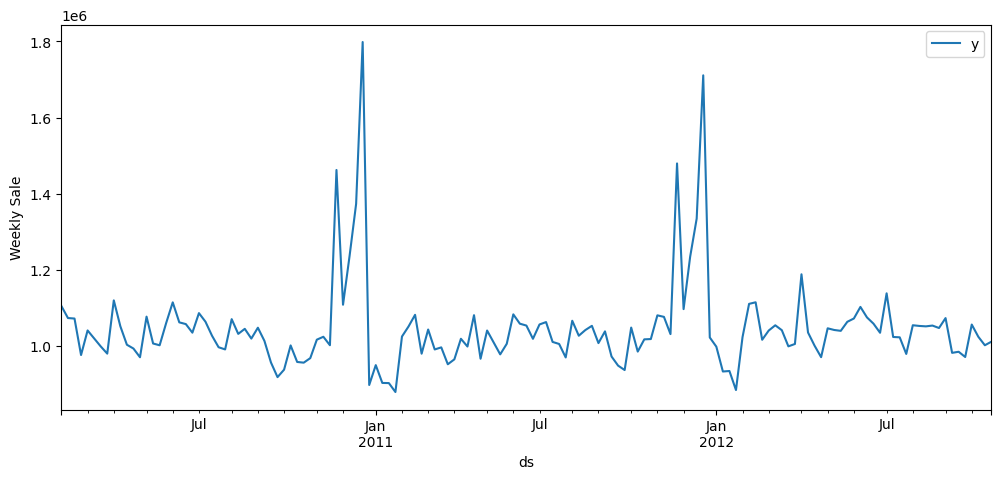

In [28]:
retail_df.plot(x='ds',
               y='y',
              ylabel='Weekly Sale');

In [29]:

test_split = 12
retail_train, retail_test = split_data(retail_df, test_split)

train: 131 , test: 12


In [30]:
from prophet.make_holidays import make_holidays_df

holidays = pd.DataFrame({
    'holiday': 'custom holiday',  # Name of the holiday
    'ds': retail_train[retail_train['Holiday_Flag'] == 1]['ds'],
})

years = retail_df['ds'].dt.year.unique().tolist()
us_holidays = make_holidays_df(year_list=years,
                            country='US')

holidays = pd.concat([holidays, us_holidays])
holidays

,holiday,ds
1,custom holiday,2010-02-12
31,custom holiday,2010-09-10
42,custom holiday,2010-11-26
47,custom holiday,2010-12-31
53,custom holiday,2011-02-11
83,custom holiday,2011-09-09
94,custom holiday,2011-11-25
99,custom holiday,2011-12-30
105,custom holiday,2012-02-10
0,New Year's Day,2010-01-01


In [36]:
retail_train.head()

,ds,y,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,1105572.01,0.0,34.04,2.7178,167.730885,8.619
1,2010-02-12,1074148.39,1.0,34.15,2.6940,167.825608,8.619
2,2010-02-19,1072822.08,0.0,37.72,2.6721,167.871686,8.619
3,2010-02-26,977079.36,0.0,39.24,2.6839,167.909657,8.619
4,2010-03-05,1041588.23,0.0,42.92,2.7312,167.947628,8.619


In [31]:
model_retail = Prophet(seasonality_mode='additive', holidays=holidays)
model_retail.add_regressor('Temperature')
model_retail.add_regressor('Fuel_Price')
model_retail.add_regressor('CPI')
model_retail.add_regressor('Unemployment')

model_retail.fit(retail_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3rb7k9g1/7289p397.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3rb7k9g1/r4jqcu13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2891', 'data', 'file=/tmp/tmp3rb7k9g1/7289p397.json', 'init=/tmp/tmp3rb7k9g1/r4jqcu13.json', 'output', 'file=/tmp/tmp3rb7k9g1/prophet_modelf14rlt54/prophet_model-20250915083306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [33]:
retail_future = model_retail.make_future_dataframe(len(retail_test), freq='W-FRI')
retail_future

,ds
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05
...,...
138,2012-09-28
139,2012-10-05
140,2012-10-12
141,2012-10-19


In [37]:
retail_future = retail_future.merge(retail_df[['ds',
                                                  'Temperature',
                                                  'Fuel_Price',
                                                  'CPI',
                                                  'Unemployment']],
                                       on='ds', how='left')

In [38]:
retail_forecast = model_retail.predict(retail_future)

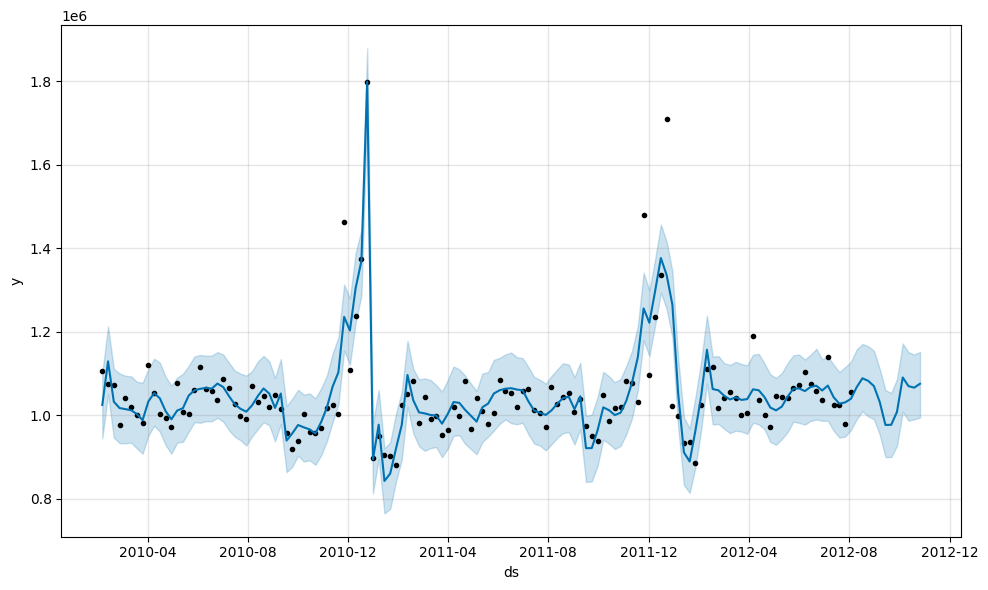

In [41]:
model_retail.plot(retail_forecast);

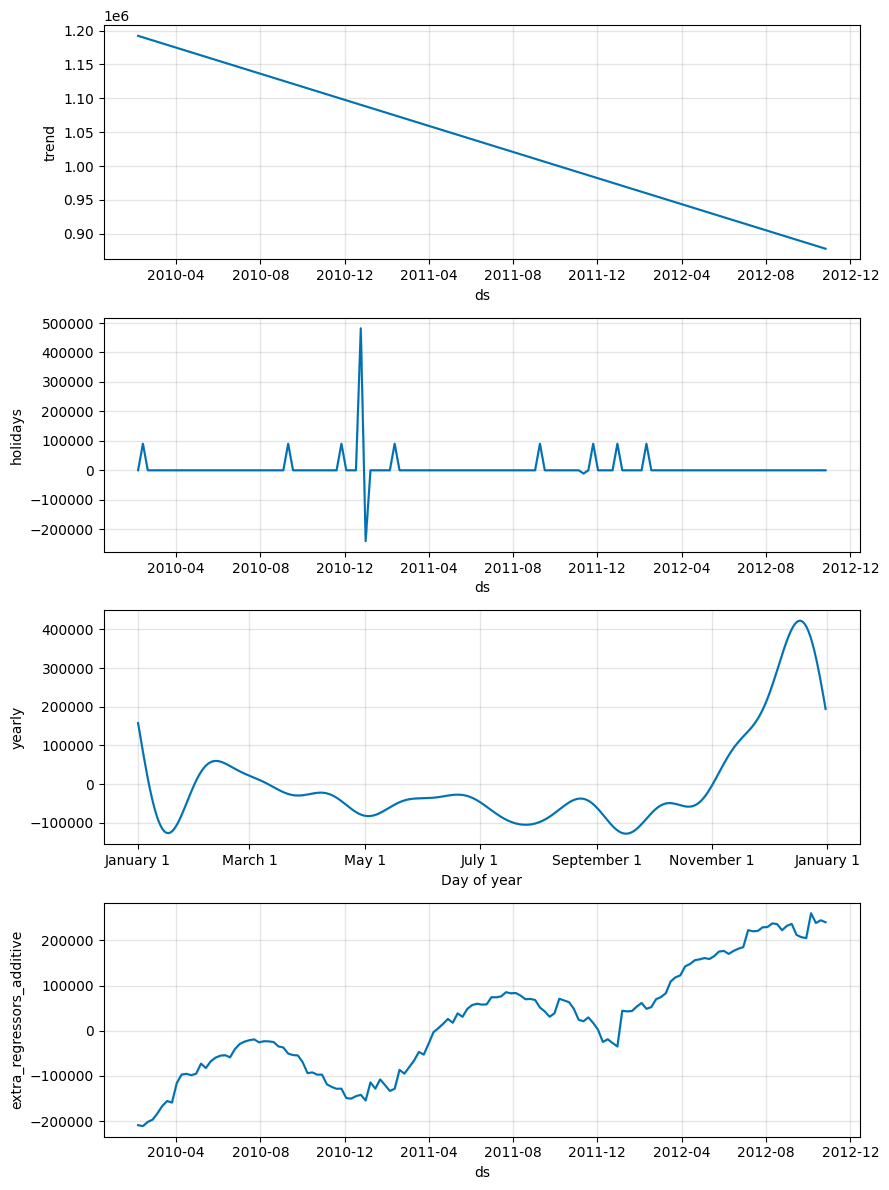

In [42]:
model_retail.plot_components(retail_forecast);


<Axes: title={'center': 'Forecasts vs Actual'}, xlabel='ds', ylabel='Weekly Sales'>

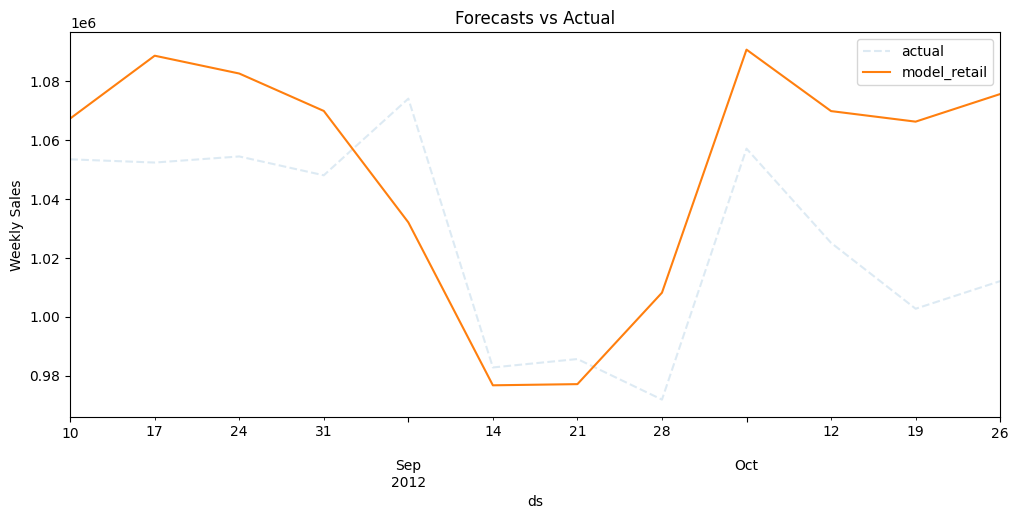

In [43]:
ax = retail_test.plot(x='ds',
                      y='y',
                      style='--',
                      label='actual',
                      alpha=0.15,
                      title='Forecasts vs Actual',
                      ylabel='Weekly Sales')
retail_forecast.tail(12).plot(x='ds', y='yhat', ax=ax,
                                 label='model_retail',
                                 style='-')

## Student Activity
* In this activity you will read the `air_passenger.csv`: Air Passengers per month


In [48]:
# Read the dataset and ensure that the columns are renamed to `ds` and `y`
air_passenger = Path('/content/air_passenger.csv')
air_df = # YOUR CODE
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      144 non-null    datetime64[ns]
 1   y       144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [50]:
def split_data(data, test_split):
    """Split time series data into training and test sets.

    Args:
        data (pd.Series or pd.DataFrame): Time series data to split
        test_split (int): Number of periods to use for testing

    Returns:
        tuple: (train_data, test_data)
    """
    t_idx = test_split
    train, test = data[ : -t_idx], data[-t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [51]:
# Split the Time Series into train and test. Hold out (Test) to be 12 months
test_split = # YOUR CODE
train, test = # YOUR CODE

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

train: 132 , test: 12
Train: (132, 2)
Test: (12, 2)


<Axes: xlabel='ds'>

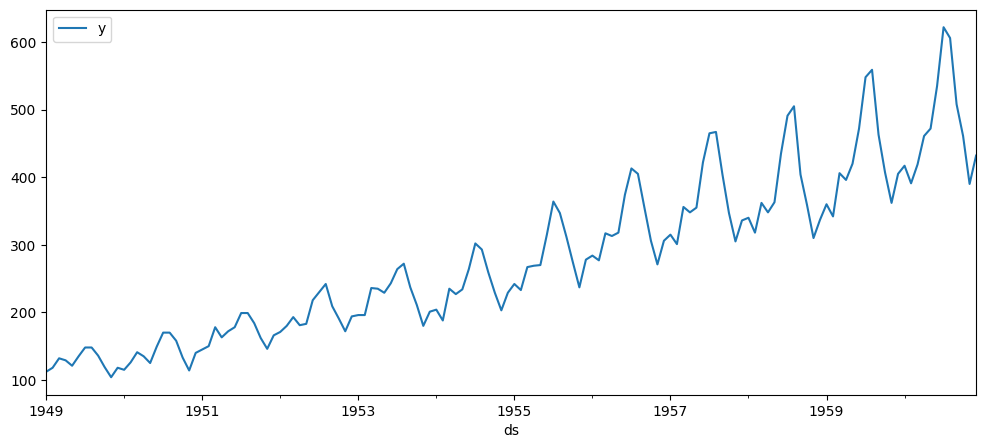

In [52]:
air_df.plot(x='ds', y='y')

In [53]:
# Create and fit the model
model = # YOUR CODE



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3rb7k9g1/3hdcqxyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3rb7k9g1/lcq1i9gg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97851', 'data', 'file=/tmp/tmp3rb7k9g1/3hdcqxyi.json', 'init=/tmp/tmp3rb7k9g1/lcq1i9gg.json', 'output', 'file=/tmp/tmp3rb7k9g1/prophet_modeldgy6a65n/prophet_model-20250915084058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:40:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:40:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [54]:
# Create placeholder for future forecasts
future = # YOUR CODE

In [55]:
# Create the forecast
forecast = # YOUR CODE

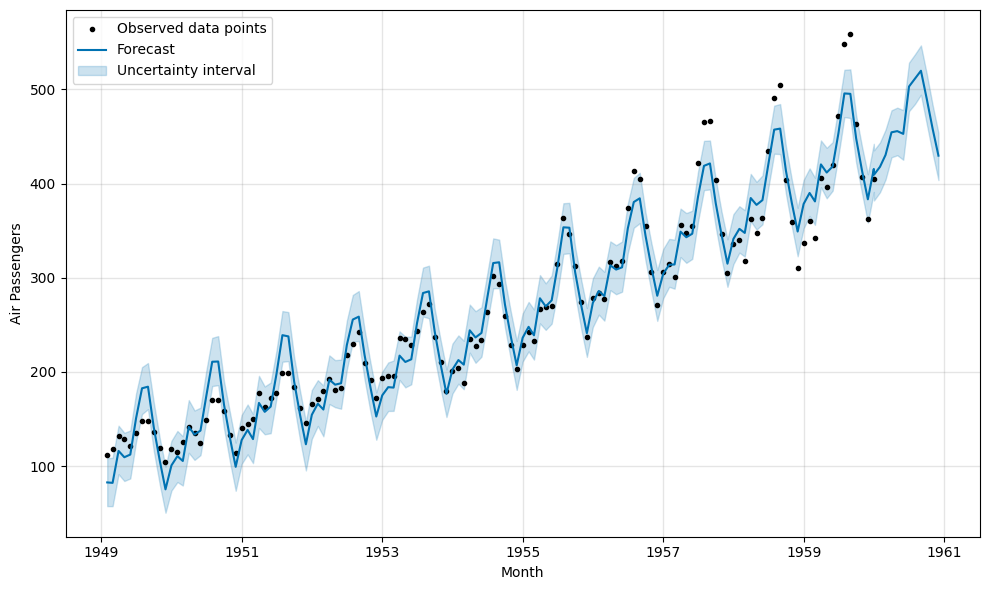

In [56]:
# Plot the forecast
# YOUR CODE

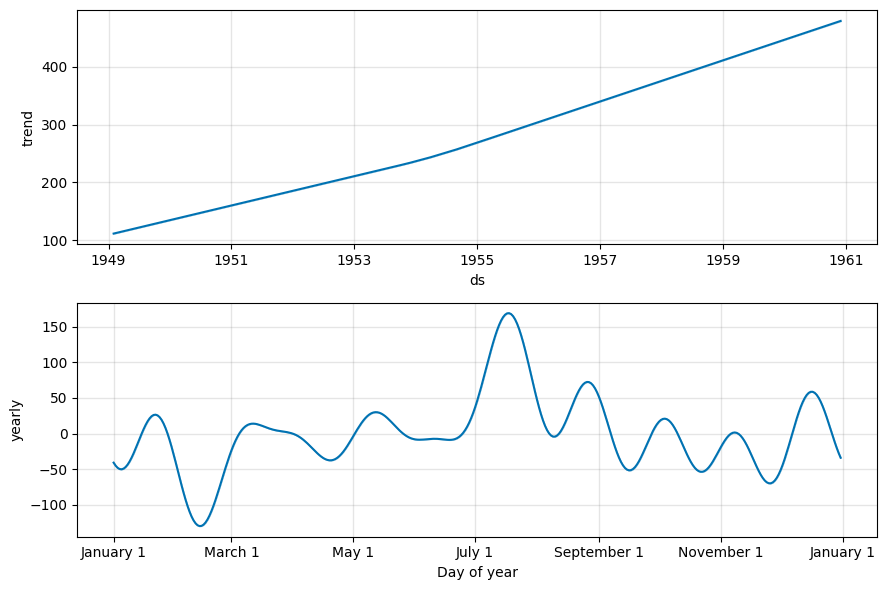

In [59]:
# Plot the components
# YOUR CODE

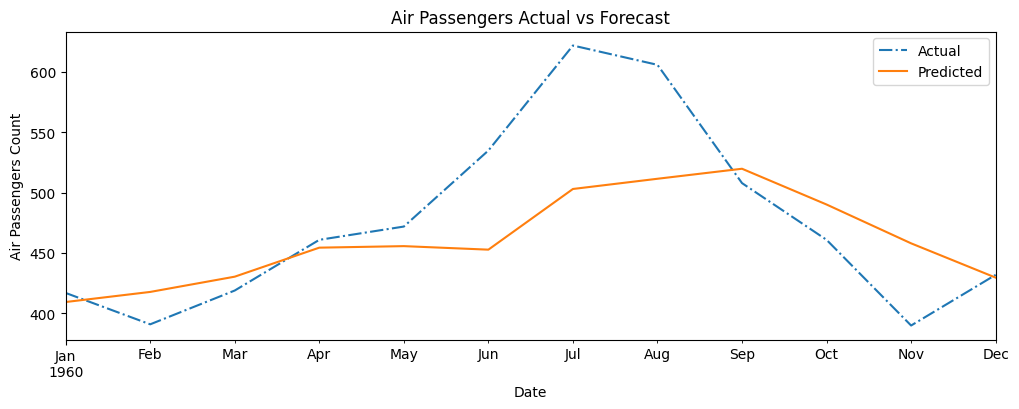

In [64]:
# Plot actual vs forecast